In [1]:
import os
import string
from pathlib import Path

import gensim.downloader as api
import kagglehub
import nltk
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchmetrics import F1Score, MetricCollection

In [2]:
torch.set_float32_matmul_precision("medium")

In [3]:
data_dir = kagglehub.dataset_download("andrewmvd/trip-advisor-hotel-reviews")

In [4]:
csv_files = list(Path(data_dir).glob("*.csv"))

if len(csv_files) == 1:
    data_path = csv_files[0]
    print(f"Found CSV file: {data_path}")
elif len(csv_files) > 1:
    file_names = [file.name for file in csv_files]
    raise ValueError(f"More than one CSV file found: {file_names}")
else:
    raise FileNotFoundError("No CSV files found in the directory.")

Found CSV file: /home/reveur/.cache/kagglehub/datasets/andrewmvd/trip-advisor-hotel-reviews/versions/2/tripadvisor_hotel_reviews.csv


  # Выбор метрик оценки

In [5]:
df = pd.read_csv(data_path)
print(df["Rating"].value_counts().sort_index() * 100 / len(df))

Rating
1     6.934752
2     8.750183
3    10.658338
4    29.471475
5    44.185252
Name: count, dtype: float64


  Мы видим сильный дисбаланс классов, поэтому будем использовать:
  - F1-score с параметром average="macro" - уравновешивает вклад всех классов, акцент на малочисленных классах
  - F1-score с параметром average="weighted" - учитывает дисбаланс классов, больше вес крупных классов

In [6]:
resources = [
    "punkt",
    "stopwords",
    "wordnet",
    "punkt_tab",
]

for resource in resources:
    nltk.download(resource)

[nltk_data] Downloading package punkt to /home/reveur/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/reveur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/reveur/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/reveur/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [7]:
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words("english"))
        self.punctuation = set(string.punctuation)
        self.glove = api.load("glove-wiki-gigaword-100")
        self.embedding_dim = 100

    def preprocess_text(self, text):
        tokens = word_tokenize(text.lower())
        tokens = [
            token
            for token in tokens
            if token not in self.punctuation
            and token not in self.stop_words
            and not token.isnumeric()
        ]
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        return tokens

    def text_to_embedding(self, tokens, max_length=100):
        embeddings = []
        for token in tokens[:max_length]:
            if token in self.glove:
                embeddings.append(self.glove[token])
            else:
                embeddings.append(np.zeros(self.embedding_dim))

        while len(embeddings) < max_length:
            embeddings.append(np.zeros(self.embedding_dim))

        return torch.FloatTensor(np.array(embeddings))

In [8]:
class HotelReviewsDataset(Dataset):
    def __init__(self, texts, ratings):
        self.preprocessor = TextPreprocessor()
        self.texts = []

        for text in texts:
            tokens = self.preprocessor.preprocess_text(text)
            embedding = self.preprocessor.text_to_embedding(tokens)
            self.texts.append(embedding)

        self.ratings = ratings

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.ratings[idx]

In [9]:
class HotelReviewsDataModule(pl.LightningDataModule):
    def __init__(self, data_path: str, batch_size: int = 32):
        super().__init__()
        self.data_path = data_path
        self.batch_size = batch_size
        self.num_workers = os.cpu_count()

    def prepare_data(self):
        df = pd.read_csv(self.data_path)
        self.df = df[["Review", "Rating"]]

        self.le = LabelEncoder()
        self.df["Rating"] = self.le.fit_transform(self.df["Rating"])

        self.train_val_df, self.test_df = train_test_split(
            self.df, test_size=0.2, stratify=self.df["Rating"], random_state=42
        )

        self.train_df, self.val_df = train_test_split(
            self.train_val_df,
            test_size=0.25,
            stratify=self.train_val_df["Rating"],
            random_state=42,
        )

    def setup(self, stage: str):
        if stage == "fit":
            self.train_dataset = HotelReviewsDataset(
                self.train_df["Review"].values,
                torch.tensor(self.train_df["Rating"].values),
            )
            self.val_dataset = HotelReviewsDataset(
                self.val_df["Review"].values, torch.tensor(self.val_df["Rating"].values)
            )

        if stage == "test":
            self.test_dataset = HotelReviewsDataset(
                self.test_df["Review"].values,
                torch.tensor(self.test_df["Rating"].values),
            )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            persistent_workers=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            persistent_workers=True,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            persistent_workers=True,
        )

In [10]:
class CNNModel(pl.LightningModule):
    def __init__(self, input_dim=100, num_classes=5, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.conv1 = nn.Conv1d(input_dim, 128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(256)
        self.conv3 = nn.Conv1d(256, 512, kernel_size=7, padding=3)
        self.bn3 = nn.BatchNorm1d(512)

        self.global_pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, num_classes)

        self.metrics = MetricCollection(
            {
                "f1_macro": F1Score(
                    task="multiclass", num_classes=num_classes, average="macro"
                ),
                "f1_weighted": F1Score(
                    task="multiclass", num_classes=num_classes, average="weighted"
                ),
            }
        )
        self.train_metrics = self.metrics.clone(prefix="train_")
        self.val_metrics = self.metrics.clone(prefix="val_")
        self.test_metrics = self.metrics.clone(prefix="test_")

    def forward(self, x):
        x = x.transpose(1, 2)

        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.global_pool(x)
        x = x.squeeze(-1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.train_metrics.update(logits, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        self.log_dict(self.train_metrics.compute(), prog_bar=True)
        self.train_metrics.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.val_metrics.update(logits, y)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        self.log_dict(self.val_metrics.compute(), prog_bar=True)
        self.val_metrics.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        self.test_metrics.update(logits, y)

    def on_test_epoch_end(self):
        self.log_dict(self.test_metrics.compute(), prog_bar=True)
        self.test_metrics.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.hparams.learning_rate, weight_decay=0.01
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.5, patience=3
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
            },
        }

In [11]:
class LSTMModel(pl.LightningModule):
    def __init__(
        self, input_dim=100, hidden_dim=256, num_classes=5, learning_rate=1e-3
    ):
        super().__init__()
        self.save_hyperparameters()
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True,
            dropout=0.2,
        )
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.metrics = MetricCollection(
            {
                "f1_macro": F1Score(
                    task="multiclass", num_classes=num_classes, average="macro"
                ),
                "f1_weighted": F1Score(
                    task="multiclass", num_classes=num_classes, average="weighted"
                ),
            }
        )
        self.train_metrics = self.metrics.clone(prefix="train_")
        self.val_metrics = self.metrics.clone(prefix="val_")
        self.test_metrics = self.metrics.clone(prefix="test_")

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        attention_output = torch.sum(attention_weights * lstm_out, dim=1)
        x = self.dropout(attention_output)
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.train_metrics.update(logits, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        self.log_dict(self.train_metrics.compute(), prog_bar=True)
        self.train_metrics.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.val_metrics.update(logits, y)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        self.log_dict(self.val_metrics.compute(), prog_bar=True)
        self.val_metrics.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        self.test_metrics.update(logits, y)

    def on_test_epoch_end(self):
        self.log_dict(self.test_metrics.compute(), prog_bar=True)
        self.test_metrics.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=1e-5,
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.5, patience=3
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
            },
        }

In [12]:
pl.seed_everything(42)

Seed set to 42


42

In [13]:
datamodule = HotelReviewsDataModule(data_path)
datamodule.prepare_data()
datamodule.setup("fit")

In [14]:
cnn_model = CNNModel()
checkpoint_callback_cnn = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints",
    filename="cnn-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
    mode="min",
)

trainer = pl.Trainer(
    max_epochs=25,
    accelerator="auto",
    devices=1,
    callbacks=[
        TQDMProgressBar(refresh_rate=1),
        EarlyStopping(monitor="val_loss", mode="min", patience=3),
        checkpoint_callback_cnn,
    ],
    logger=TensorBoardLogger(save_dir="lightning_logs", name="hotel_reviews_cnn"),
    enable_progress_bar=True,
    enable_model_summary=True,
)

trainer.fit(model=cnn_model, datamodule=datamodule)
best_cnn = CNNModel.load_from_checkpoint(checkpoint_callback_cnn.best_model_path)

cnn_results = trainer.test(model=best_cnn, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name          | Type              | Params | Mode 
-------------------------------------------------------------
0  | conv1         | Conv1d            | 38.5 K | train
1  | bn1           | BatchNorm1d       | 256    | train
2  | conv2         | Conv1d            | 164 K  | train
3  | bn2           | BatchNorm1d       | 512    | train
4  | conv3         | Conv1d            | 918 K  | train
5  | bn3           | BatchNorm1d       | 1.0 K  | train
6  | global_pool   | AdaptiveMaxPool1d | 0      | train
7  | dropout       | Dropout           | 0      | train
8  | fc1           | Linear            | 131 K  | train
9  | fc2           | Linear            | 1.3 K  | train
10 | metrics       | MetricCollection  | 0      | train
11 | train_metrics | MetricCollection  | 0      | train
12 | val_metrics   | MetricCollection  | 0      | t

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_f1_macro          0.554836630821228
    test_f1_weighted        0.6252928972244263
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [15]:
lstm_model = LSTMModel()
checkpoint_callback_lstm = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints",
    filename="lstm-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
    mode="min",
)

trainer = pl.Trainer(
    max_epochs=25,
    accelerator="auto",
    devices=1,
    callbacks=[
        TQDMProgressBar(refresh_rate=1),
        EarlyStopping(monitor="val_loss", mode="min", patience=3),
        checkpoint_callback_lstm,
    ],
    logger=TensorBoardLogger(save_dir="lightning_logs", name="hotel_reviews_lstm"),
    enable_progress_bar=True,
    enable_model_summary=True,
)

trainer.fit(model=lstm_model, datamodule=datamodule)
best_lstm = LSTMModel.load_from_checkpoint(checkpoint_callback_lstm.best_model_path)
lstm_results = trainer.test(model=best_lstm, datamodule=datamodule)

/home/reveur/anaconda3/envs/itmo_dl_course/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/reveur/anaconda3/envs/itmo_dl_course/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/reveur/itmo_dl_course/extra_task_3/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | lstm          | LSTM             | 733 K  | train
1 | attention     | Linear           | 513    | train
2 | dropout       | Dropout          | 0      | train
3 | fc            | Linear           | 2.6 K  | train


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/reveur/anaconda3/envs/itmo_dl_course/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_f1_macro         0.5636386275291443
    test_f1_weighted        0.6236136555671692
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/ --host 0.0.0.0 --port 6006

# Сравнение моделей

In [19]:
print("CNN Results:", cnn_results)
print("LSTM Results:", lstm_results)

CNN Results: [{'test_f1_macro': 0.554836630821228, 'test_f1_weighted': 0.6252928972244263}]
LSTM Results: [{'test_f1_macro': 0.5636386275291443, 'test_f1_weighted': 0.6236136555671692}]


1. Метрики на тестовом наборе:
   - CNN: F1-macro = 55.48%, F1-weighted = 62.53%
   - LSTM: F1-macro = 56.36%, F1-weighted = 62.36%

2. Влияние несбалансированности классов:
   - Заметная разница между F1-macro и F1-weighted указывает на проблемы с классификацией минорных классов
   - Высокие значения F1-weighted связаны с лучшей работой на мажоритарных классах (4 и 5)

3. Сравнение процесса обучения:
   - LSTM: быстрее достигает хороших результатов, но менее стабильна на валидации
   - CNN: показывает более плавное улучшение метрик с меньшими колебаниями

Обе модели демонстрируют схожую итоговую производительность, но страдают от несбалансированности данных.

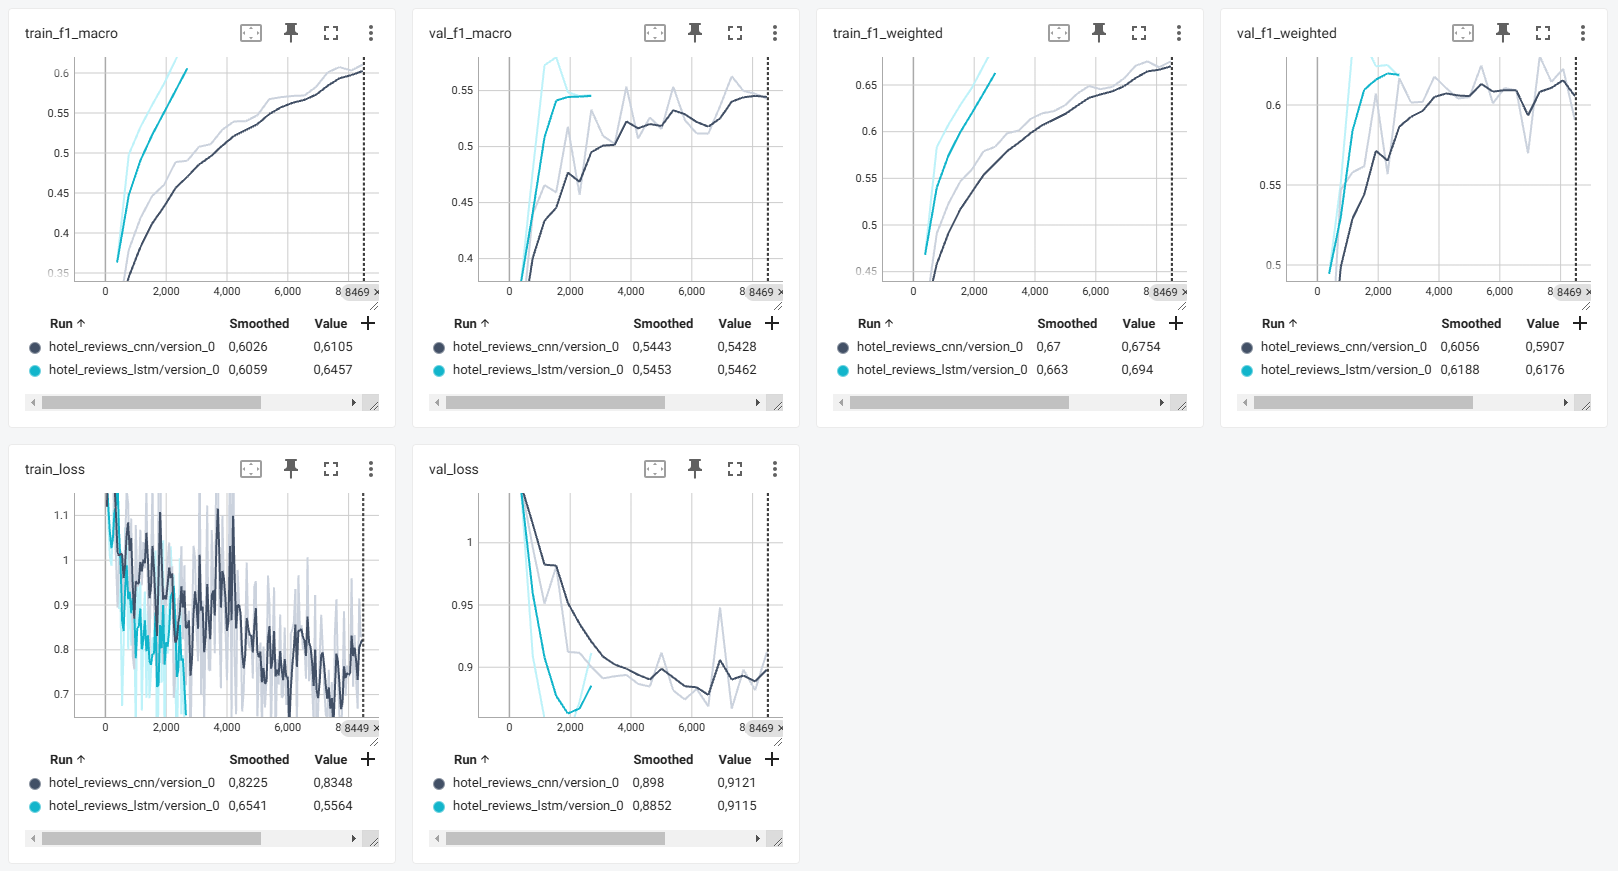